In [2]:
import os
import numpy as np
import scipy.io as sio
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

In [11]:
def load_HeartDisease():
    # Get path of files
    path = os.getcwd()
    path = path + '/data/filtHeartDataSet.mat'
    # Import data
    data = sio.loadmat(path)
    X = data['dataMatrix']  # get array from dictionary
    y_hd = data['labels']  # heart disease 
    # Change 'Yes', 'No' to 1 and 0 respectivly

    y_hd_01_list = []
    for y in range(len(y_hd)):
        if y_hd[y, 0] == ['No']:
            y_hd_01_list.append(0)
        else:
            y_hd_01_list.append(1)
    y_hd_01 = np.array(y_hd_01_list)
    return X, y_hd_01


def load_ToyData():
    path = os.getcwd()
    path = path + '/data/toydata.mat'
    data = sio.loadmat(path)
    data = data['D']  # get array from dictionary
    return data.T


In [8]:


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

   


def scikit_pca(X, var_d):
    X -= X.mean(axis=0)
    # Check how many principle components needed for desired variance
    pca = PCA()
    pca.fit(X)
    reached_var = 0 
    for v in range(len(pca.explained_variance_ratio_)):
        reached_var = reached_var + pca.explained_variance_ratio_[v]
        if reached_var >= var_d:
            break
    # PCA with desired number ov principle components
    pca2 = PCA(n_components=v+1)
    X = pca2.fit_transform(X)
    return X, reached_var, v+1    


def PCA_EVD(X, var_d):
    X -= X.mean(axis=0)
    # Mean vector of all features
    mean_vec = np.array([np.mean(vect) for vect in X.T])
    # Covariance matrix
    cov_mat = np.cov(X.T)
    # Eigenvectors and Eigenvalues
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    # Make a sorted list of (eigenvalue, eigenvector) tuples from hight to low
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) 
                 for i in range(len(eig_val))]
    eig_pairs.sort()
    eig_pairs.reverse()

    # Explained variance: how much information each componant contains
    tot = sum(eig_val)
    var_exp = np.array([(i / tot)*100 for i in sorted(eig_val, reverse=True)])*0.01
    # Determine how many Eigenvectors are needed
    var_r = 0
    dim = 0
    for var in var_exp:
        var_r = var_r+var
        if dim == 0:
            W = eig_pairs[1][1].reshape(len(eig_val),1)
        elif dim == 1:
            W = np.hstack((eig_pairs[0][1].reshape(len(eig_val),1), 
                           eig_pairs[1][1].reshape(len(eig_val),1)))
        elif dim > 1:
            W = np.hstack((W, eig_pairs[dim][1].reshape(len(eig_val),1)))
        if var_r >= var_d:
            X_proj = X.dot(W)

            return eig_pairs, dim+1, X_proj, var_exp, var_r, mean_vec
        dim = dim + 1


def PCA_SVD(X, var_d):
    # SVD (capital letter: Mat/vect)
    svd_U,svd_s,svd_Vt = np.linalg.svd(X, full_matrices = False)
    svd_V = svd_Vt.T
    svd_S = np.diag(svd_s)

    # Variance of original data
    var_original = np.var(X)

    # Variance of each axis    
    var_exp = np.array([])

    numb_used_pca = 1
    while True:
        print('* Iteration: ',numb_used_pca)
        # Reconstruct with increasing number of priciple components
        X_proj = np.dot(svd_U[:, :numb_used_pca],
                          np.dot(svd_S[:numb_used_pca, :numb_used_pca],
                                 svd_V[:,:numb_used_pca].T))
        print('svd U Shape: ',svd_U[:, :numb_used_pca].shape)
        print('svd S Shape: ',svd_S[:numb_used_pca, :numb_used_pca].shape)
        print('svd V^T Shape: ',svd_V[:,:numb_used_pca].T.shape)
        print('X_proj Shape: ',X_proj.shape)
        # Reached variance
        var_reconst = np.var(X_proj)
        var_r = var_reconst/var_original
        # Variance Explained (Variance for each PCA)
        var_exp = np.append(var_exp, var_reconst)
        print('Vergleich Variance R-D: ',var_r, var_d)
        if var_r >= var_d:
            # Principle Compo/ Reconst.Data/ num used pca/ var of reconst data
            return X_proj, numb_used_pca, var_exp, var_r

        numb_used_pca = numb_used_pca + 1
        if numb_used_pca > len(svd_s):
            print("Desired variance can't be reached with SVD")
            break


def PCA_TSVD(X, var_d):
    svd = TruncatedSVD(n_components=(len(X.T)-1), random_state=42)
    svd.fit(X) 
    reached_var = 0 
    for v in range(len(svd.explained_variance_ratio_)):
        reached_var = reached_var + svd.explained_variance_ratio_[v]
        if reached_var >= var_d:
            break
    svd2 = TruncatedSVD(n_components=v+1, random_state=42)
    X = svd2.fit_transform(X)
    return X, reached_var, v+1   


def demeaned_data(X):
    mean_vec = np.array([np.mean(vect) for vect in X.T])
    X_demeaned = np.array([X.T[dim]-mean_vec[dim] for dim in range(len(X.T))])
    return X_demeaned.T, mean_vec


def problem_1():
    var_d = 0.98    # Set desired variance percentage
    X_orig = load_ToyData()
    X_demeaned, mean_vec_orig = demeaned_data(X_orig)

    # PCA on Toydata
    [eig_pairs, num_eig_V, X_proj_evd, var_exp_evd, var_r_evd, 
     mean_vec_pca] = PCA_EVD(X_orig, var_d)
    print('**********************************************')
    print('*                     PCA                    *')
    print('**********************************************')
    print('Needed Dim:', num_eig_V)
    print('X shape: ', X_proj_evd.shape)    
    print('Reched Variance: ', var_r_evd)
    print('Variance distributed over the dimensions: ', var_exp_evd)
    print('Eigen pair 1: ', eig_pairs[0])
    print('Eigen pair 2: ', eig_pairs[1])
    print('Eigen pair 3: ', eig_pairs[2])


    # Plot original vs transformed datasets
    # subplot 1_1    // // // Original Data \\ \\ \\
    fig1 = plt.figure(1)
    ax11 = fig1.add_subplot(121, projection='3d')
    ax11.plot(X_demeaned.T[0], X_demeaned.T[1], X_demeaned.T[2], 'o',                  # Original Data
              markersize=8, color='blue', alpha=0.7)
    ax11.plot([mean_vec_pca[0]], [mean_vec_pca[1]], [mean_vec_pca[2]], 'o',
             markersize=10, color='red', alpha=0.9)  
    ax11.set_xlabel('x1')
    ax11.set_ylabel('x2')
    ax11.set_zlabel('x3')
    ax11.set_title('Orignal (Demeaned) Data')
    # eigenvector arrows
    for i in range(len(eig_pairs)):        
        a = Arrow3D([mean_vec_pca[0], 10*var_exp_evd[i]*eig_pairs[i][1][0]], 
                    [mean_vec_pca[1], 10*var_exp_evd[i]*eig_pairs[i][1][1]], 
                    [mean_vec_pca[2], 10*var_exp_evd[i]*eig_pairs[i][1][2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
        ax11.add_artist(a)
    #                 // // // PCA Data \\ \\ \\
    [eig_pairs_2, num_eig_V_2, X_proj_evd_2, var_exp_evd_2, var_r_evd_2, 
     mean_vec_pca_2] = PCA_EVD(X_proj_evd, 1)
    # subplot 1_2
    ax12 = fig1.add_subplot(122, projection='3d')
    ax12.plot(X_proj_evd.T[0], X_proj_evd.T[1], X_proj_evd.T[2], 'o',      # Original Data
              markersize=8, color='green', alpha=0.7)
    ax12.plot([mean_vec_pca[0]], [mean_vec_pca[1]], [mean_vec_pca[2]], 'o',
              markersize=10, color='red', alpha=0.9)  
    ax12.set_xlabel('x1')
    ax12.set_ylabel('x2')
    ax12.set_zlabel('x3')
    ax12.set_title('PCA Data')
    # eigenvector arrows
    for i in range(len(eig_pairs)):        
        a = Arrow3D([mean_vec_pca_2[0], 10*var_exp_evd_2[i]*eig_pairs_2[i][1][0]], 
                    [mean_vec_pca_2[1], 10*var_exp_evd_2[i]*eig_pairs_2[i][1][1]], 
                    [mean_vec_pca_2[2], 10*var_exp_evd_2[i]*eig_pairs_2[i][1][2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
        ax12.add_artist(a)





problem_1()


**********************************************
*                     PCA                    *
**********************************************
Needed Dim: 3
X shape:  (100, 3)
Reched Variance:  1.0
Variance distributed over the dimensions:  [ 0.63598182  0.28291333  0.08110485]
Eigen pair 1:  (7.2120704354817615, array([-0.60872641,  0.29276835,  0.7373865 ]))
Eigen pair 2:  (3.2082533915265752, array([-0.21103554, -0.95569087,  0.20522905]))
Eigen pair 3:  (0.91973365310244692, array([ 0.76479812, -0.03068641,  0.6435388 ]))


In [9]:


def problem_2():
    """
    1. Find the eigenvectors and the corresponding eigenvalues that preserve at 
       least 98% of the variance.
    2. Project your data to the first three principle components (eigenvectors) and 
       visualize the point cloud based on their corresponding labels, i.e. red colors for
       heart disease, green colors for normal patients.
    """
    var_d = 0.98    # Set desired variance percentage

    X, y = load_HeartDisease()

    X_proj_scikit, var_r_scikit, dim_scikit = scikit_pca(X,var_d)
    [eig_pairs, num_eig_V, X_proj_evd, var_exp_evd, var_r_evd, 
     mean_vec] = PCA_EVD(X, var_d)
    X_proj_svdt, var_r_svdt, dim_svdt = PCA_TSVD(X, var_d)

    # Terminal output
    print('**********************************************')
    print('*                     PCA                    *')
    print('**********************************************')
    print('SciKit: Needed Dim: ', dim_scikit)
    print('SciKit: X shape: ', X_proj_scikit.shape)
    print('SciKit: Reched Var: ', var_r_scikit)
    print('EVD: Needed Dim:', num_eig_V)
    print('EVD: X shape: ', X_proj_evd.shape)    
    print('EVD: Reched Variance: ', var_r_evd) 
    print('SVDT: Needed Dim:', dim_svdt)
    print('SVDT: X shape: ', X_proj_svdt.shape)  
    print('SVDT: Reched Variance: ', var_r_svdt)
    print('**********************************************')
    print('Variance of the features: \n', var_exp_evd)
    print('**********************************************')

    # Plot
    fig2 = plt.figure(2)
    colors_plot = ['green', 'red']
    ax21 = fig2.add_subplot(111, projection='3d')
    ax21.scatter(X_proj_evd.T[0], X_proj_evd.T[1], X_proj_evd.T[2], 'o',
                 s=30, alpha=0.6, c=y,
                 cmap=matplotlib.colors.ListedColormap(colors_plot))
    red_patch = mpatches.Patch(color='red', label='Heart Disease')
    plt.legend(handles=[red_patch],loc=4)
    ax21.set_xlabel('x1')
    ax21.set_ylabel('x2')
    ax21.set_zlabel('x3')
    ax21.set_title('Heart Disease data after dimensionality reduction with PCA')


**********************************************
*                     PCA                    *
**********************************************
SciKit: Needed Dim:  3
SciKit: X shape:  (299, 3)
SciKit: Reched Var:  0.982995523875
EVD: Needed Dim: 3
EVD: X shape:  (299, 3)
EVD: Reched Variance:  0.982995523875
SVDT: Needed Dim: 3
SVDT: X shape:  (299, 3)
SVDT: Reched Variance:  0.982995523875
**********************************************
Variance of the features: 
 [  7.47011673e-01   1.50372937e-01   8.56109136e-02   1.59899308e-02
   3.74229955e-04   2.54713923e-04   1.89928151e-04   6.07446982e-05
   5.79765046e-05   4.50866483e-05   3.18654199e-05]
**********************************************


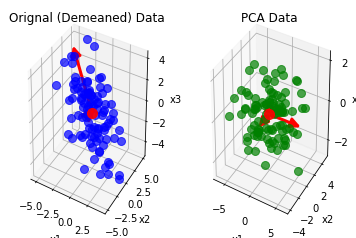

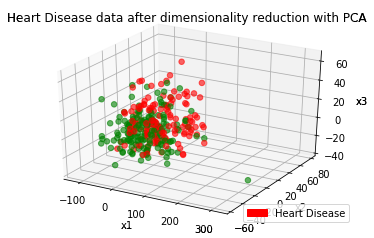

In [10]:
problem_2()
plt.show()
